In [47]:
from os import stat_result
import numpy as np
import tensorflow as tf
from tensorflow.python.ops.gen_array_ops import reverse
import tensorflow_probability as tfp
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
from sklearn import cluster, datasets, mixture
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
rcParams['figure.dpi'] = 300

In [ ]:
def checkerboard(height, width, r=False):
    """
    Takes in the dimensions of the checkerboard mask to be produced.
    Will output a 2D tf tensor containing a checkerboard pattern of 1s and 0s.
    """
    checkerboard = [[(i + j) % 2 for j in range(width)] for i in range(height)]
    return tf.convert_to_tensor(checkerboard, dtype='float32')

In [33]:
class RNVP(tf.keras.Model):
    def __init__(self, depth, prior_dim):
        super(RNVP, self).__init__()

        """
        Takes in the depth of each component network in the Model (depth) as well as the dimension of the density we're estimating (prior_dim).
        The structure of the Model has four main components, the mask, the prior, the t-network and the s-network.
        In init we construct each of these according to the specifications described by depth and prior_dim
        """
        ## Construct prior
        ## We assume for simplicity the prior is a MVN of the same dimension as the input data
        self.prior = tfp.distributions.MultivariateNormalTriL(loc=tf.zeros(prior_dim), scale_tril=tf.eye(prior_dim))
        ## Construct mask
        self.height = depth * prior_dim  
        self.mask = checkerboard(self.height,prior_dim)
        ## Initialize t and s network lists
        ## The number of networks in the list should be the same as the number of rows in mask
        ## Each network should have number of layers = depth, the last layer in each s network should have tanh activation
        self.t = [Sequential()] * self.height
        self.s = [Sequential()] * self.height 
        self.hidden_size = 256
        ## Fill each network in both network lists
        for j in range(self.height):
            for i in range(depth-1):
                self.t[j].add(tf.keras.layers.Dense(self.hidden_size,activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
                self.s[j].add(tf.keras.layers.Dense(self.hidden_size,activation=tf.keras.layers.LeakyReLU(alpha=0.01)))
            self.t[j].add(tf.keras.layers.Dense(prior_dim))
            self.s[j].add(tf.keras.layers.Dense(prior_dim,activation='tanh'))


    def call(self, x):
        """
        When the layers have been fully learned, this call will transform data from an arbitrary
        distribution to data from a multivariate normal distribution in an invertible way 

        Inputs:
            x: A sample distribution of size (num_samples x prior_dim)
        Returns:
            output_dist: forward transform of x, what the original distribution looks like in the latent space (prior distribution)
            sldj: the log determinant of the Jacobian for the s network layers
        """
        ## Initialize our output_dist as our input_dist x, we will iteratively update it until it looks normal
        output_dist = x
        num_samples = x.shape[0]
        sldj = tf.zeros([num_samples])
        ## Loop through each row in the mask and each network in t and s 
        for i in range(self.height):
            ## Mask and reverse mask will each be of shape (prior_dim)
            mask = self.mask[i]
            reverse_mask = 1 - mask
            ## The variables s and t in the loop will be networks with number of layers = depth
            s = self.s[i]
            t = self.t[i]
            ## First apply the forward mask to output_dist
            ## output_dist_masked will have the same shape as output_dist (num_samples x prior_dim)
            output_dist_masked = mask * output_dist
            ## Pass this through s and t and subsequently apply reverse mask
            ## s_out and t_out will be of size (num_samples x prior_dim)
            s_out = s(output_dist_masked)* reverse_mask
            t_out = t(output_dist_masked)* reverse_mask
            ## Update output_dist via the transformation described in equation (8) of this paper https://arxiv.org/pdf/1605.08803.pdf
            ## We add the un-updated output_dist_masked to the updated output_dist multiplied by the reverse mask 
            updated_dist = (output_dist-t_out) * tf.math.exp(-1 * s_out)
            output_dist = output_dist_masked + reverse_mask * updated_dist
            ## We also update the log of the determinant of the Jacobian at each step of the transformation according
            ## to equation (6) from the same paper. Note we are subtracting away instead of adding because we are looking at the reverse transformation
            ## of the one described in the paper. We still want to maximize this sldj value even though it's negative
            sldj -= tf.math.reduce_sum(s_out, axis=1)

        return output_dist, sldj


    def loss_function(self, output_dist, sldj):
        """
        By the change of variable theory, computing the density on a point x is accomplished by
        computing the density of its image f(x) and multiplying by the associated Jacobian determinant
        of the transformation (3) | we can thus define our negative log likelihood (which we hope to minimize)
        as the average of our sldj output subtracted out from the negative prior log probability of the output distribution

        Inputs:
            output_dist: latent space distribution 
            sldj: negative log of the determinant of the jacobian of the transformation 
        Returns:
            loss: average negative log likelihood as described above
        """
        ## Negative prior log probability of the output distribution
        npp = -self.prior.log_prob(output_dist)
        ## Subtract out log determinant of jacobian 
        nlls = npp - sldj
        ## Average and return 
        return tf.reduce_mean(nlls)

  
    def sample (self, num_samples):
      ## Randomly sample from prior
      input_dist = self.prior.sample([num_samples])
      ## Run inverse transformation (ie do the steps in call but backwards)
      for i in reversed(range(self.height)):
        ## Mask and reverse mask will each be of shape (prior_dim)
        mask = self.mask[i]
        reverse_mask = 1 - mask
        ## The variables s and t in the loop will be networks with number of layers = depth
        s = self.s[i]
        t = self.t[i]
        ## First apply the forward mask to input_dist
        input_dist_masked = mask * input_dist
        ## Pass this through s and t and subsequently apply reverse mask
        s_out = s(input_dist_masked)* reverse_mask
        t_out = t(input_dist_masked)* reverse_mask
        ## Update input_dist via the transformation described in equation (7) of this paper https://arxiv.org/pdf/1605.08803.pdf
        input_dist = input_dist_masked + reverse_mask * (t_out + input_dist * tf.math.exp(s_out))
      return input_dist
      




In [36]:
flow = RNVP(depth = 3, prior_dim = 2)

In [43]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
for t in range(5001):   
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    with tf.GradientTape() as tape:
      z, sldj = flow.call(tf.convert_to_tensor(noisy_moons))
      loss = flow.loss_function(z, sldj)
    gradients = tape.gradient(loss, flow.trainable_variables)
    optimizer.apply_gradients(zip(gradients, flow.trainable_variables))
    
    if t % 200 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 1.380
iter 200: loss = 1.266
iter 400: loss = 1.026
iter 600: loss = 1.122
iter 800: loss = 1.027
iter 1000: loss = 0.987
iter 1200: loss = 1.047
iter 1400: loss = 1.008
iter 1600: loss = 1.072
iter 1800: loss = 1.011
iter 2000: loss = 0.961
iter 2200: loss = 0.926
iter 2400: loss = 1.031
iter 2600: loss = 0.863
iter 2800: loss = 0.903
iter 3000: loss = 1.070
iter 3200: loss = 0.936
iter 3400: loss = 1.027
iter 3600: loss = 0.979
iter 3800: loss = 0.963
iter 4000: loss = 0.956
iter 4200: loss = 1.062
iter 4400: loss = 0.919
iter 4600: loss = 1.031
iter 4800: loss = 0.888
iter 5000: loss = 0.867


(1000, 2)


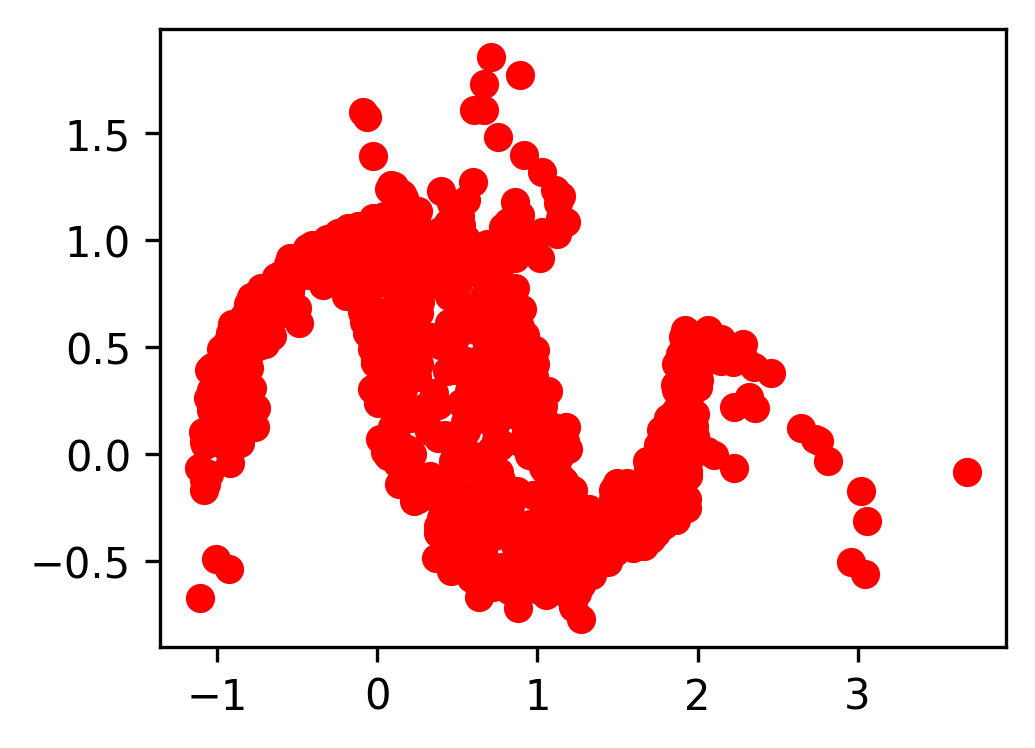

In [48]:
plt.subplot(224)
x = flow.sample(1000).numpy()
print(x.shape)
plt.scatter(x[:,0],x[:,1], c='r')
